#### Run to download mergedDf.csv from google drive if your file is missing

In [3]:
# Download CSV file from google drive and save it if you haven't already
import gdown

files = {
    "mergedDF.csv": {
        "file_id": "1QQfgbD412WRYOyODlSMlFF8Gx9_Jv0Hl",
        "output": "../data/mergedDF.csv",
    },
    "all_posts_with_sentiment.csv": {
        "file_id": "14glkamRUcm6biMnyJIIaDCT9asCE64qs",
        "output": "../data/all_posts_with_sentiment.csv",
    },
}


for download in files:
    file_id = files[download]['file_id']
    output = files[download]['output']
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QQfgbD412WRYOyODlSMlFF8Gx9_Jv0Hl
To: C:\Users\jackk\Documents\Abroad Classes\Computational Analysis of Big Data\SqueezeNet\data\mergedDF.csv
100%|██████████| 57.4M/57.4M [00:08<00:00, 7.07MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=14glkamRUcm6biMnyJIIaDCT9asCE64qs
From (redirected): https://drive.google.com/uc?id=14glkamRUcm6biMnyJIIaDCT9asCE64qs&confirm=t&uuid=b2873bbc-d579-46e7-9cd0-247a1ff8813a
To: C:\Users\jackk\Documents\Abroad Classes\Computational Analysis of Big Data\SqueezeNet\data\all_posts_with_sentiment.csv
100%|██████████| 106M/106M [00:16<00:00, 6.61MB/s] 


#### Import all needed modules

In [4]:
# Base Tools
import pandas as pd
import numpy as np

# Custom classes
from DataPlug import DataPlug as dp
from SqueezeNet import SqueezeNet as sq

# Network tools
from sklearn.model_selection import train_test_split # Splitting the data
from sklearn.ensemble import RandomForestRegressor # Model that we are using

# Visualization Tools
from sklearn.tree import export_graphviz # Graph visualization of tree
from IPython.display import Image # Display image of tree
import pydot # Graph visualization of tree

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jackk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Initiate instances of our custom classes
squeeze = sq("SqueezeNet")
dataPlug = dp("DataPlug")

#### Load the dataframe from a file

In [6]:
# If you want to load the mergedDF from a csv file
dataPlug.mergedDF = pd.read_csv('../data/mergedDF.csv')
dataPlug.mergedDF = dataPlug.mergedDF.drop('Unnamed: 0', axis=1)
# Drop unused column info
dataPlug.mergedDF = dataPlug.mergedDF.drop('Open', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Low', axis=1)

dataPlug.mergedDF = dataPlug.mergedDF.drop('Adj Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('title', axis=1)

# Might need to keep this, not sure yet
timestamp_info = dataPlug.mergedDF['timestamp']
dataPlug.mergedDF = dataPlug.mergedDF.drop('timestamp', axis=1)


##### Take a look at the data if you'd like to

In [7]:
display(dataPlug.mergedDF)

,High,Close,Volume,score,num_comments,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Compound_Sentiment
0,5.380000,5.3175,19562000,13.000000,22.000000,0.000000,0.000000,1.000000,0.000000
1,5.427500,5.3900,8414800,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,5.550000,5.5375,16022400,6.500000,10.500000,0.102500,0.000000,0.897500,0.238350
3,5.635000,5.5725,14128400,7.000000,4.000000,0.000000,0.000000,1.000000,0.000000
4,5.677500,5.5950,12587200,4.000000,0.000000,0.165000,0.158000,0.677000,0.025800
...,...,...,...,...,...,...,...,...,...
2155,18.165001,15.0000,102749200,1.113846,4.526374,0.152009,0.044976,0.800815,0.150271
2156,14.250000,12.5775,107372400,1.000714,17.286530,0.141212,0.050631,0.807442,0.130000
2157,15.707500,12.8000,145820000,6.080738,12.311236,0.150552,0.038095,0.808944,0.163170
2158,13.830000,12.7750,52226800,1.887141,19.164354,0.147041,0.043510,0.807590,0.145756


#### Split the data into features/labels and testing/training sets

In [8]:
#labels = np.array(dataPlug.mergedDF['High'])
#labels = np.array(dataPlug.mergedDF['Volume'])
labels = np.array(dataPlug.mergedDF['Close'])

dataPlug.mergedDF = dataPlug.mergedDF.drop('Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('High', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Volume', axis=1)

feature_list = list(dataPlug.mergedDF.columns)
dataPlug.features = np.array(dataPlug.mergedDF)

train_features, test_features, train_labels, test_labels = train_test_split(dataPlug.features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1620, 6)
Training Labels Shape: (1620,)
Testing Features Shape: (540, 6)
Testing Labels Shape: (540,)


In [9]:
print(labels)

[ 5.3175  5.39    5.5375 ... 12.8    12.775  13.1   ]


In [10]:

print(test_features[0][feature_list.index('Positive_Sentiment')])

0.1195113024757804


#### Import and train the network

In [11]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print(f'Training Complete! {squeeze.name} is ready to make predictions!')

Training Complete! SqueezeNet is ready to make predictions!


#### Make predictions on the test set

In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')



# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.57 degrees.
Accuracy: 70.95 %.


### Save the model's full tree visualization to a file

In [13]:
# Ensure filepath sync
import os
os.makedirs('../data/tree', exist_ok=True)

In [14]:
# Path to save files to (no extension)
path_no_extension = '../data/tree/tree'

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = f'{path_no_extension}.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file(f'{path_no_extension}.dot')
# Write graph to a png file
graph.write_png(f'{path_no_extension}.png')

### Save the model's small tree visualization to a file

In [15]:
path_no_extension = '../data/tree/small_tree'

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]


# Save the tree as a png image
export_graphviz(tree_small, out_file = f'{path_no_extension}.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file(f'{path_no_extension}.dot')
graph.write_png(f'{path_no_extension}.png');

#### Display the small tree

In [24]:
path_no_extension = '../data/visualizations/small_tree'
graph.write_png(f'{path_no_extension}.png')

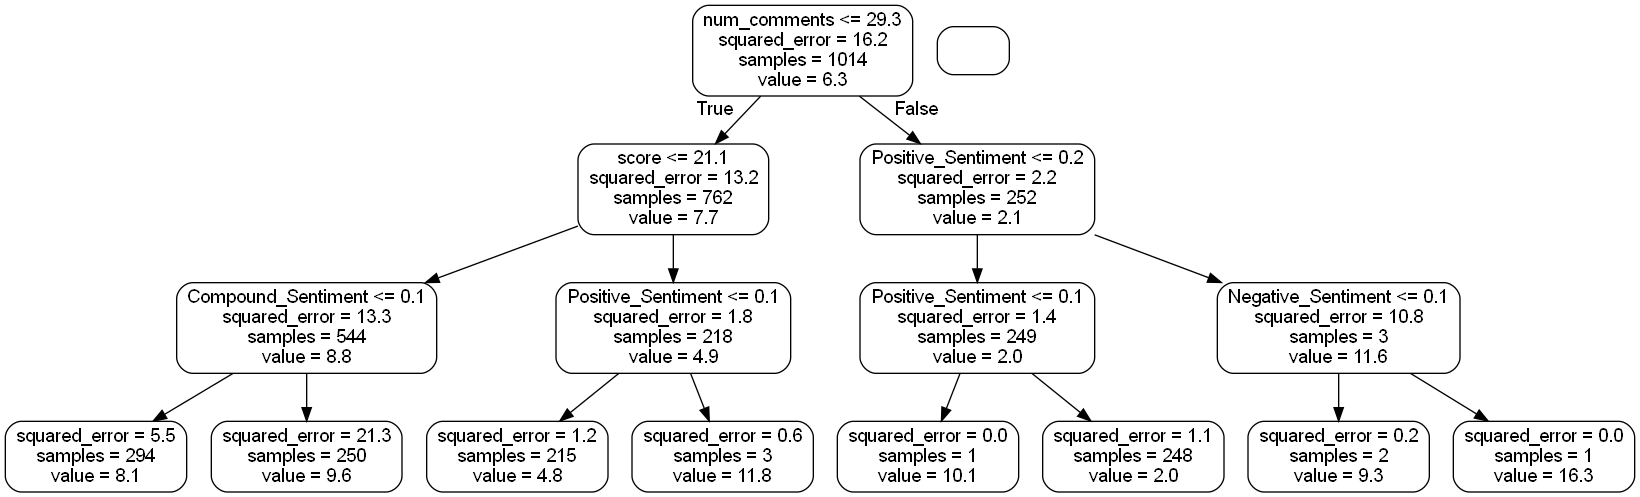

In [25]:
Image(f'{path_no_extension}.png')

#### Get numerical feature importance for the model

In [17]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: num_comments         Importance: 0.44
Variable: score                Importance: 0.27
Variable: Neutral_Sentiment    Importance: 0.11
Variable: Positive_Sentiment   Importance: 0.07
Variable: Compound_Sentiment   Importance: 0.06
Variable: Negative_Sentiment   Importance: 0.04


#### Plot the feature importances

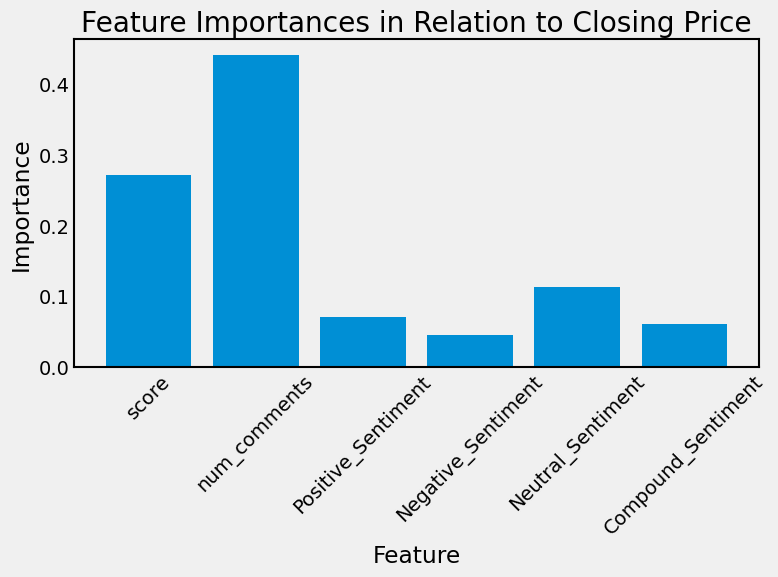

In [63]:
fig = plt.figure(figsize=(8, 6))
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances in Relation to Closing Price')
plt.xticks(rotation = 45)

filename = "Feature Importances in Relation to Closing Price".replace(" ", "_") + '.png'

# remove gridlines from figure
ax = fig.gca()
ax.grid(False)

plt.savefig(f'../data/visualizations/{filename}', bbox_inches='tight')

#### Plot actual vs predicted values

> Note: This section is not working yet. I'm not sure how to get the dates to work properly.
>> Reference [this article for visulization](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)

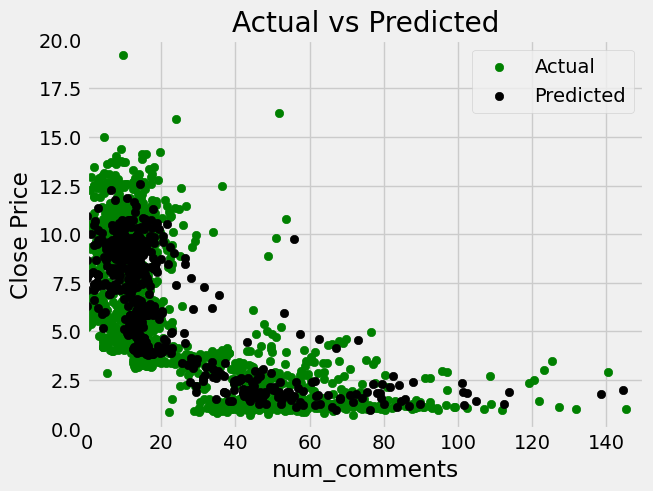

In [19]:

plt.scatter(train_features[:,feature_list.index('num_comments')], train_labels, color='g')
plt.scatter(test_features[:, feature_list.index('num_comments')], predictions, color='k')
plt.xlabel('Number of Comments')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted')
plt.legend(['Actual', 'Predicted'])
plt.xlim(0,150)
plt.ylim(0,20)
plt.show()

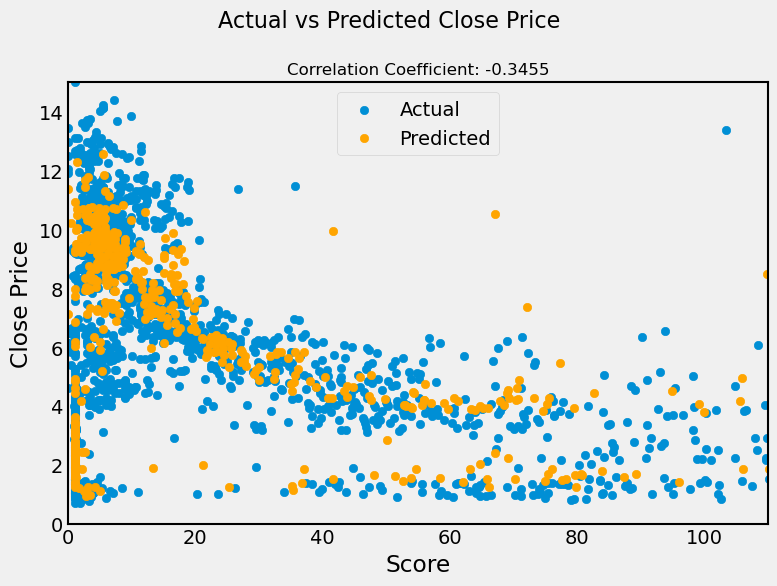

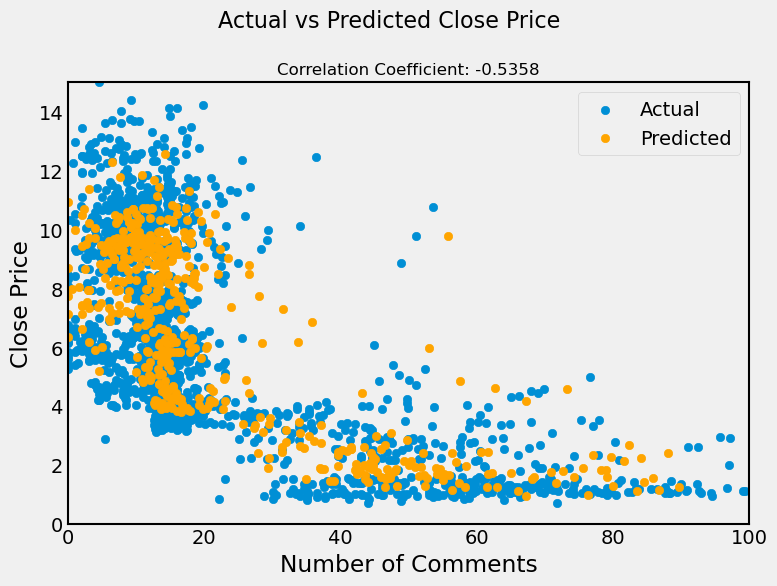

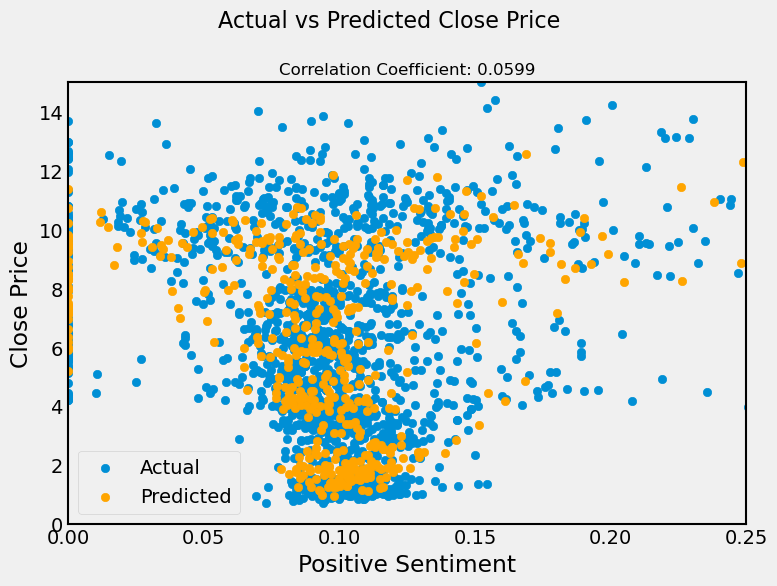

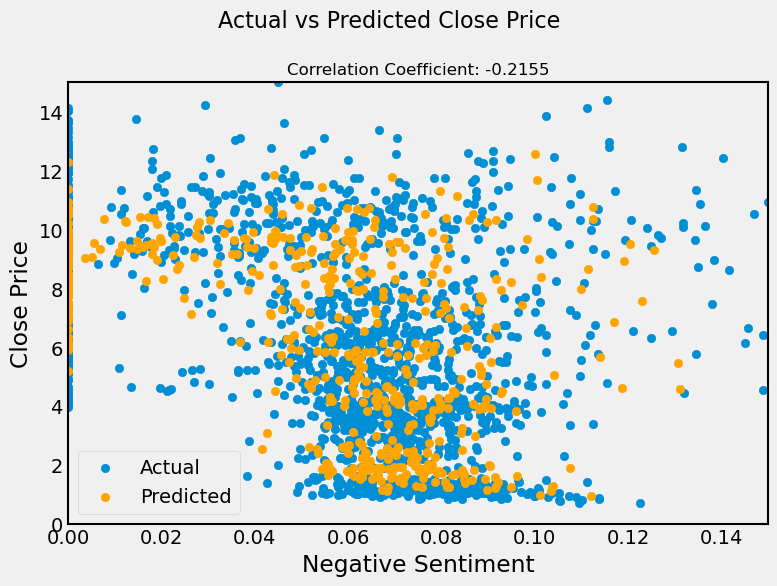

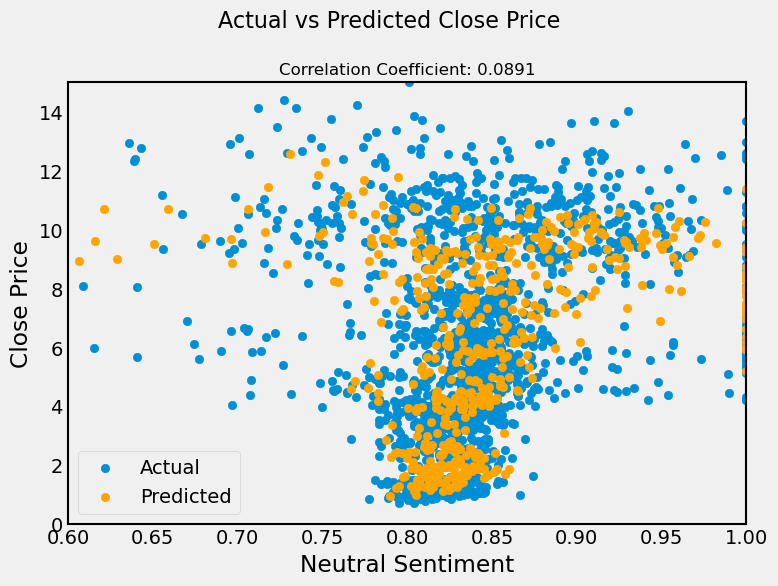

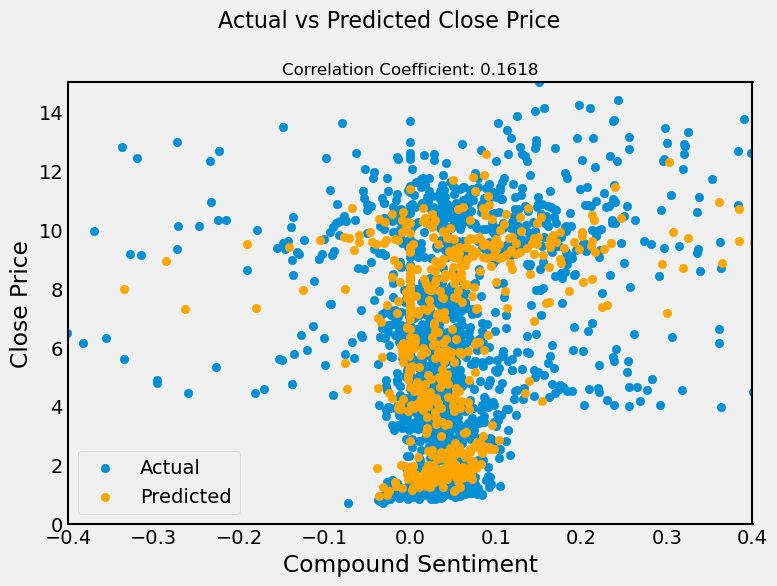

In [62]:

limits = {
          'score': [0,110],
          'num_comments': [0,100],
          'Positive_Sentiment': [0,0.25],
          'Negative_Sentiment': [0,0.15],
          'Neutral_Sentiment': [0.6,1],
          'Compound_Sentiment': [-0.4,0.4],
}

for feature in feature_list:

    fig = plt.figure(figsize=(8,6))
    plt.rcParams["figure.figsize"] = [8, 6]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.50
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.spines.bottom'] = True
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = True
    plt.scatter(train_features[:,feature_list.index(feature)], train_labels, color='C0')
    plt.scatter(test_features[:, feature_list.index(feature)], predictions, color='orange')
    # find the r value for these scatter plots
    r = np.corrcoef(train_features[:,feature_list.index(feature)], train_labels)


    plt.ylabel('Close Price')
    title = 'Actual vs Predicted Close Price'
    suptit = plt.suptitle(title, fontsize=16)

    plt.legend(['Actual', 'Predicted'])

    plt.ylim(0,15)
    plt.xlim(limits[feature])

    if feature == 'score':
        feature = 'Score'
    elif feature == 'num_comments':
        feature = 'Number of Comments'
    else:
        feature = feature.replace('_', ' ')

    plt.xlabel(feature)
    tit = plt.title(f"Correlation Coefficient: {round(r[0][1],4)}", fontsize=12)

    filename = f'{title} ({feature})'.replace(" ", "_") + '.png'
    #plt.show()

    # add border to figure

    # remove gridlines from figure
    ax = fig.gca()
    ax.grid(False)

    plt.savefig(f'../data/visualizations/{filename}', bbox_inches="tight")

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt


mse = mean_squared_error(test_labels, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {sqrt(mse)}')

Mean Squared Error: 19.1063899228025
Root Mean Squared Error: 4.371085668664308
